# 1. - Introducción

En este trabajo vamos a obtener datos en tiempo real usando la API de Streaming de Twitter. Para ello hemos de ingresar en Twitter con nuestra cuenta y darnos de alta como desarrolladores. Una vez hecho esto podemos crear nuestra aplicación y Twitter nos proporcionará las contraseñas necesarias para poderla hacer operativa. Los tweets que vamos a recopilar están enfocados en el contexto de los debates políticos de los días 2019-04-22 y 2019-04-23, previos a las elecciones del día 2019-04-28, en los que se enfrentan los secretarios generales de los principales partidos políticos españoles.

Dado que esperamos recopilar un gran número de tweets vamos a hacer uso de la conocida herramienta de Big Data Spark para su análisis, en concreto vamos a hacer uso de `pyspark`, su API para el lenguaje de programación python. Para que nuestro trabajo sea totalmente reproducible vamos a hacer uso de Docker, una herramiento que permite crear aplicaciones en contenedores aislados de forma que puedan ser ejecutadas en condiciones idénticas por cualquier persona. En concreto vamos a usar el contenedor oficial `jupyter/pyspark-notebook`, para conseguir este entorno basta con ejecutar el siguiente comando en la terminal de docker

`docker run -it --rm -p 8888:8888 jupyter/pyspark-notebook`

Una vez tenemos el entorno preparado podemos proceder a la recopilación de los tweets. Para ello vamos a hacer uso de `tweepy`, la API de Twitter para python. Para que esta esté disponible en nuesto entorno debemos instalarla usando la siguiente línea de código

`! pip install tweepy`

Finalmente, después de esto podemos configurar nuestro Streaming para capturar los tweets relacionados con los debates y análizar los diferentes campos que estos contienen, obteniendo así una serie de visualizaciones que nos permitan entender a grandes rasgos como se ha desarrollado este debate y la impresión que ha tenido la gente del mismo.

# 2. - Librerías

Primero nos aseguramos de que todas las librerías que vamos a utilizar están disponibles

In [2]:
# Basics
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud 
import PIL 

# Twitter 
import tweepy
import json
from pytz import timezone
from datetime import datetime
import re
import nltk
import collections 

# Spark
import pyspark
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import col, udf, round, explode, unix_timestamp

# 3. - Streaming en Twitter

La primera parte de nuestro análisis consiste en capturar los tweets relacionados con las elecciones. Para ello debemos darnos de alta como desarrolladores en nuestro perfil de Twitter para obtener las contraseñas y los permisos necesarios para poder crear nuestra applicación. Una vez hecho esto Twitter nos proporcionará cuatro claves, `consumer_key`, `consumer_secret`, `access_token` y `access_token_secret`, que por nuestra privacidad ocultaremos en el código que sigue.

Para capturar estos tweets necesitamos aplicar una serie de filtros a los datos del Streaming, pues solo queremos capturar los tweets relacionados con el debate. Por esto, solo capturaremos tweets publicados en español y filtraremos estos usando como palabras claves los nombres de los participantes en el debate, las siglas de sus partidos políticos y otra serie de palabras clave relacionadas con este asunto.

In [4]:
# Passwords
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

Una vez tenemos esto preparado ya podemos crear nuestra aplicación de Streaming, de forma que guarde todos los tweets que vamos a analizar de forma integra, para poder asegurar la reproducibilidad de nuestro análisis.

## 3.1.- Debate del día 2019-04-22

In [ ]:
# Filters
to_track = ["ELDEBATEenRTVE",
            "Sánchez", "PSOE",
            "Casado", "PP",
            "Iglesias", "Podemos",
            "Rivera", "Ciudadanos",
            "Abascal", "VOX"
            ]

# Create streaming object
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api = None):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open("Debate1.txt", "a")

    def on_status(self, status):
        tweet = status._json
        self.file.write( json.dumps(tweet) + '\n' )
        self.num_tweets += 1
        if self.num_tweets < 1000000000:
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print(status)

# Make it work
l = MyStreamListener()
stream = tweepy.Stream(auth, l)
stream.filter(track = to_track, languages = ["es"], stall_warnings = True)

## 3.2.- Debate del día 2019-04-23

In [ ]:
# Filters
to_track = ["DebateDecisivoARV", "ElDebateDecisivo", "DebateAtresmedia",
            "Sánchez", "PSOE",
            "Casado", "PP",
            "Iglesias", "Podemos",
            "Rivera", "Ciudadanos",
            "Abascal", "VOX"
            ]

# Create streaming object
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api = None):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open("DebateATM.txt", "a")

    def on_status(self, status):
        tweet = status._json
        self.file.write( json.dumps(tweet) + '\n' )
        self.num_tweets += 1
        if self.num_tweets < 1000000000:
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print(status)

# Make it work
l = MyStreamListener()
stream = tweepy.Stream(auth, l)
stream.filter(track = to_track, languages = ["es"], stall_warnings = True)

# 4. - Análisis de los tweets

Dado que hemos obtenido un gran número de tweets es conveniente hacer uso de herramientas de big data para tratar estos. En concreto vamos a hacer uso de Apache Spark a traves de su API en python, pyspark. Para empezar con esto iniciamos Spark

In [3]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SQLContext(sparkContext = sc)

de forma que ya podemos hacer uso de todas las característica que este nos proporciona, cargar los datos y quedarnos solo con los tweets correspondientes al debate

In [4]:
to_datetime = udf(lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y"), TimestampType())

data1 = spark.read.json("Debate1.txt") \
            .withColumn("created_at", to_datetime(col("created_at"))) \
            .withColumn("created_at", (unix_timestamp(col("created_at")) + 4997).cast('timestamp')) \
            .filter(col("created_at") >= "2019-04-22 22:00:00") \
            .filter(col("created_at") <= "2019-04-22 23:59:59")

data2 = spark.read.json("DebateATM.txt") \
            .withColumn("created_at", to_datetime(col("created_at"))) \
            .withColumn("created_at", (unix_timestamp(col("created_at")) + 4997).cast('timestamp')) \
            .filter(col("created_at") >= "2019-04-23 22:00:00") \
            .filter(col("created_at") <= "2019-04-23 23:59:59")

## 4.1. - Análisis de participación

Para empezar nuestro análisis podemos hacer un estudio genérico de los datos obtenidos, podemos estudiar por ejemplo los datos de participación viendo el número de tweets publicados

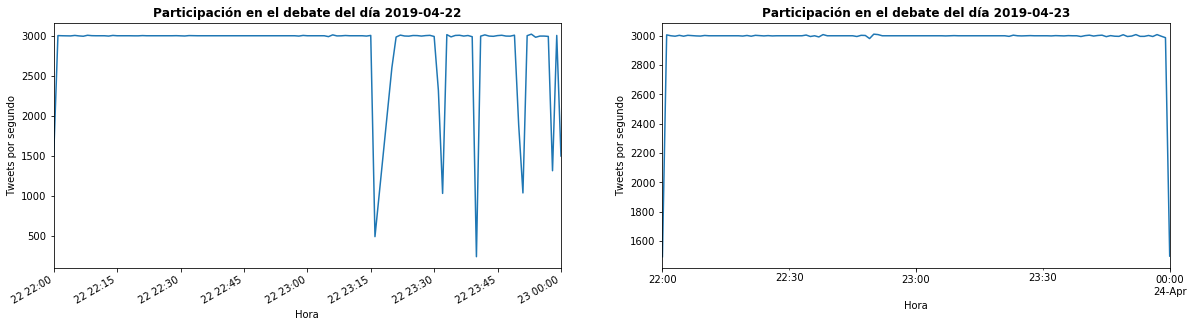

In [197]:
# Define the function for getting time counts
def get_time_counts(data):
    times = data \
            .withColumn("created_at_min", (round(unix_timestamp(col("created_at")) / 60) * 60).cast('timestamp')) \
            .groupBy(col("created_at_min")) \
            .count() \
            .orderBy(col("created_at_min")) \
            .toPandas() \
            .set_index("created_at_min")
    return times

# Create the figure
plt.figure(figsize = (20,5))
# Make plot for the first day
plt.subplot(1,2,1)
get_time_counts(data1).plot(kind = "line", legend = None, ax=plt.gca())
plt.xlabel("Hora")
plt.ylabel("Tweets por segundo")
plt.title("Participación en el debate del día 2019-04-22", weight = "bold")
# Make plot for the second day
plt.subplot(1,2,2)
get_time_counts(data2).plot(kind = "line", legend = None, ax=plt.gca())
plt.xlabel("Hora")
plt.ylabel("Tweets por segundo")
plt.title("Participación en el debate del día 2019-04-23", weight = "bold")
# Show the figure
plt.show()

donde podemos ver que la participación ha sido tan alta que hemos sobrepasado el límite de tweets que podemos capturar en tiempo real usando la API standard de Twitter, para un análisis más en detalle deberíamos usar la API Premium.

## 4.2. - Análisis de usuarios

También podemos estudiar los usuarios que han intervenido viendo, por ejemplo, cuales han sido los más activos

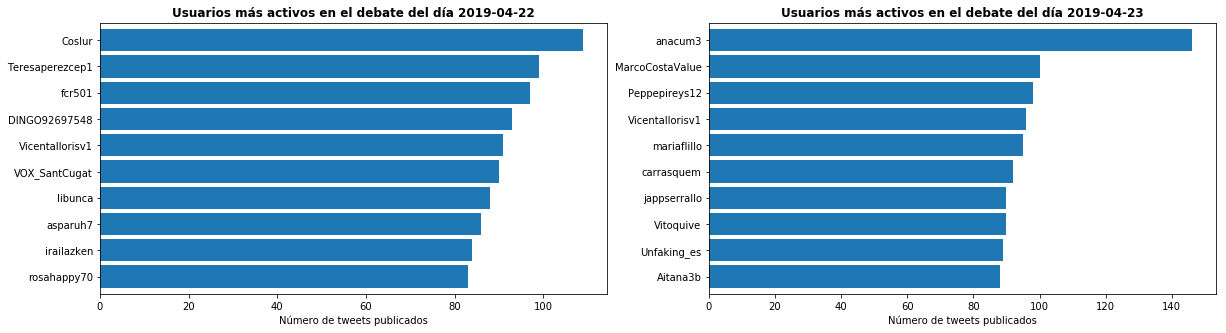

In [196]:
# Define the function for getting user counts
def get_user_counts(data):
    users = data \
            .select(col("user.*")) \
            .select(col("screen_name")) \
            .groupBy(col("screen_name")) \
            .count() \
            .orderBy([col("count"), col("screen_name")], ascending = [0, 1]) \
            .limit(10) \
            .orderBy([col("count"), col("screen_name")], ascending = [1, 1]) \
            .toPandas()
    return users

# Create the figure
plt.figure(figsize = (20,5))
# Make plot for the first day
plt.subplot(1,2,1)
get_user_counts(data1).plot(x = "screen_name", y = "count", kind = "barh", zorder = 2, width = 0.85, legend = None, ax = plt.gca())
plt.xlabel("Número de tweets publicados")
plt.ylabel("")
plt.title("Usuarios más activos en el debate del día 2019-04-22", weight = "bold")
# Make plot for the second day
plt.subplot(1,2,2)
get_user_counts(data2).plot(x = "screen_name", y = "count", kind = "barh", zorder = 2, width = 0.85, legend = None, ax = plt.gca())
plt.xlabel("Número de tweets publicados")
plt.ylabel("")
plt.title("Usuarios más activos en el debate del día 2019-04-23", weight = "bold")
# Show the figure
plt.show()

donde vemos que excepto @Vicentallorisv1 no coinciden los resultados de actividad.

## 4.3. - Análisis de candidatos

Ahora podemos analizar el texto de los tweets

In [6]:
# Define the function to get text from tweets
def get_text(data):
    texts = data \
            .select(col("text")) \
            .toPandas()
    return texts

text1 = get_text(data1)
text2 = get_text(data2)

para ver cuánto está dando que hablar cada candidato a través, por ejemplo, de las menciones que se hacen de él

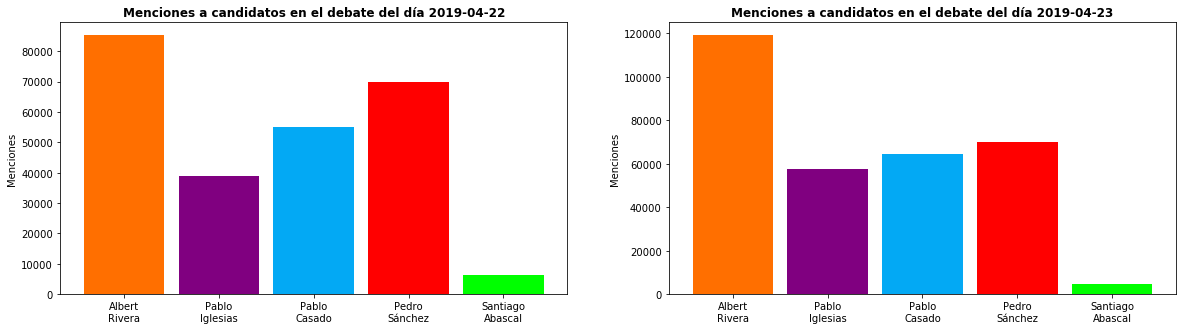

In [21]:
# Set the custom colors for each political party
ciudadanos = "#FF6F00"
podemos    = "#800080"
pp         = "#03A9F4"
psoe       = "#FF0000"
vox        = "#00FF00"

colors = [ciudadanos, podemos, pp, psoe, vox]

# Create table with the counts of mentions by candidate
candidate_counts1 = pd.Series()
candidate_counts1.loc["Albert\nRivera"]    = text1["text"].apply(lambda x: x.lower().count("rivera")).sum() + text1["text"].apply(lambda x: x.lower().count("ribera")).sum()
candidate_counts1.loc["Pablo\nIglesias"]   = text1["text"].apply(lambda x: x.lower().count("iglesias")).sum()
candidate_counts1.loc["Pablo\nCasado"]     = text1["text"].apply(lambda x: x.lower().count("casado")).sum()
candidate_counts1.loc["Pedro\nSánchez"]    = text1["text"].apply(lambda x: x.lower().count("sánchez")).sum() + text1["text"].apply(lambda x: x.lower().count("sanchez")).sum()
candidate_counts1.loc["Santiago\nAbascal"] = text1["text"].apply(lambda x: x.lower().count("abascal")).sum() + text1["text"].apply(lambda x: x.lower().count("avascal")).sum()

candidate_counts2 = pd.Series()
candidate_counts2.loc["Albert\nRivera"]    = text2["text"].apply(lambda x: x.lower().count("rivera")).sum() + text1["text"].apply(lambda x: x.lower().count("ribera")).sum()
candidate_counts2.loc["Pablo\nIglesias"]   = text2["text"].apply(lambda x: x.lower().count("iglesias")).sum()
candidate_counts2.loc["Pablo\nCasado"]     = text2["text"].apply(lambda x: x.lower().count("casado")).sum()
candidate_counts2.loc["Pedro\nSánchez"]    = text2["text"].apply(lambda x: x.lower().count("sánchez")).sum() + text1["text"].apply(lambda x: x.lower().count("sanchez")).sum()
candidate_counts2.loc["Santiago\nAbascal"] = text2["text"].apply(lambda x: x.lower().count("abascal")).sum() + text1["text"].apply(lambda x: x.lower().count("avascal")).sum()

# Create the figure
plt.figure(figsize = (20,5))
# Make plot for the first day
plt.subplot(1,2,1)
candidate_counts1.plot(kind = "bar", zorder = 2, width = 0.85, legend = None, color = colors, ax = plt.gca())
plt.xlabel("")
plt.ylabel("Menciones")
plt.title("Menciones a candidatos en el debate del día 2019-04-22", weight = "bold")
plt.xticks(rotation=0)
# Make plot for the second day
plt.subplot(1,2,2)
candidate_counts2.plot(kind = "bar", zorder = 2, width = 0.85, legend = None, color = colors, ax = plt.gca())
plt.xlabel("")
plt.ylabel("Menciones")
plt.title("Menciones a candidatos en el debate del día 2019-04-23", weight = "bold")
plt.xticks(rotation=0)
# Show the figure
plt.show()

y lo mismo con sus respectivos partidos

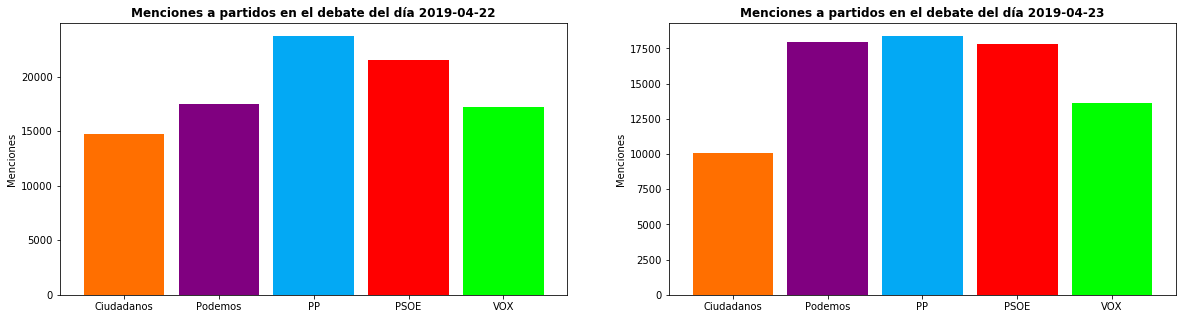

In [22]:
# Create table with the counts of mentions by party
party_counts1 = pd.Series()
party_counts1.loc["Ciudadanos"] = text1["text"].apply(lambda x: x.lower().count("ciudadanos")).sum()
party_counts1.loc["Podemos"]    = text1["text"].apply(lambda x: x.lower().count("podemos")).sum()
party_counts1.loc["PP"]         = text1["text"].apply(lambda x: x.lower().count("pp")).sum()
party_counts1.loc["PSOE"]       = text1["text"].apply(lambda x: x.lower().count("psoe")).sum()
party_counts1.loc["VOX"]        = text1["text"].apply(lambda x: x.lower().count("vox")).sum()

party_counts2 = pd.Series()
party_counts2.loc["Ciudadanos"] = text2["text"].apply(lambda x: x.lower().count("ciudadanos")).sum()
party_counts2.loc["Podemos"]    = text2["text"].apply(lambda x: x.lower().count("podemos")).sum()
party_counts2.loc["PP"]         = text2["text"].apply(lambda x: x.lower().count("pp")).sum()
party_counts2.loc["PSOE"]       = text2["text"].apply(lambda x: x.lower().count("psoe")).sum()
party_counts2.loc["VOX"]        = text2["text"].apply(lambda x: x.lower().count("vox")).sum()

# Create the figure
plt.figure(figsize = (20,5))
# Make plot for the first day
plt.subplot(1,2,1)
party_counts1.plot(kind = "bar", zorder = 2, width = 0.85, legend = None, color = colors, ax = plt.gca())
plt.xlabel("")
plt.ylabel("Menciones")
plt.title("Menciones a partidos en el debate del día 2019-04-22", weight = "bold")
plt.xticks(rotation=0)
# Make plot for the second day
plt.subplot(1,2,2)
party_counts2.plot(kind = "bar", zorder = 2, width = 0.85, legend = None, color = colors, ax = plt.gca())
plt.xlabel("")
plt.ylabel("Menciones")
plt.title("Menciones a partidos en el debate del día 2019-04-23", weight = "bold")
plt.xticks(rotation=0)
# Show the figure
plt.show()

donde vemos que Albert Rivera ha sido el candidato que más ha dado que hablar por un amplio márgen, sobre todo durante el segundo debate. Observando los partidos es curioso el hecho de que VOX, aún no estando presente en los debates sí ha tenido bastante presencia en los comentarios.

## 4.4. - Análisis de textos

Ahora vamos a analizar el texto de los tweets, para ello hemos de hacer un preprocesado de los datos

In [29]:
# Procesado estándar
def remove_pattern(pattern, text):
    to_remove = re.findall(pattern, text)
    for i in to_remove:
        text = re.sub(i, " ", text)
    return text

# Definir la función de preprocesado
def preprocessing(tweets_df):        
    list_of_tweets = tweets_df.tolist()
    
    list_of_tweets = [tweet.replace(r"http\S+", "")   for tweet in list_of_tweets] #hipervínculos
    list_of_tweets = [tweet.replace(r"https\S+", "")   for tweet in list_of_tweets] #hipervínculos
    list_of_tweets = [remove_pattern(r"@\w+", tweet)  for tweet in list_of_tweets] #nombres de usuario
    list_of_tweets = [tweet.lower()                   for tweet in list_of_tweets] #todo en minúsculas
    list_of_tweets = [remove_pattern(r"\d+", tweet)   for tweet in list_of_tweets] #números
    list_of_tweets = [remove_pattern(r"\s\s+", tweet) for tweet in list_of_tweets] #espacios adicionales
    list_of_tweets = [remove_pattern(r"rt", tweet)    for tweet in list_of_tweets] #retweets

    # Tokenizar los tweets
    TwTknz = nltk.tokenize.TweetTokenizer()
    tweets_tokenized = [TwTknz.tokenize(tweet) for tweet in list_of_tweets]

    # Eliminar las stop-words y el vocabulario específico
    stop_words = nltk.corpus.stopwords.words("spanish")
    stop_words = stop_words + ["debate", "ciudadanos", "podemos", "pp", "psoe",
                               "rivera", "iglesias", "casado", "sánchez", "sanchez", "abascal",
                               "albert", "pablo", "pedro", "santiago",
                               "ahora", "dice", "dicho", "sido", "albe", "solo", "puede", "hacer", "vez", "ver", "ser",
                               "habla", "hablar", "decir", "ido", "usted", "señor", "toca", "cada", "hoy", "dos", "hace"]
    tweets_tokenized_clean = []
    for tweet in tweets_tokenized:
        tweet = [word for word in tweet if word.isalpha()]
        tweet = [word for word in tweet if len(word) > 2]
        tweet = [word for word in tweet if word not in stop_words]
        tweets_tokenized_clean.append(tweet)
    
    return tweets_tokenized_clean

y ver las palabras más frecuentes en los comentarios sobre el discurso

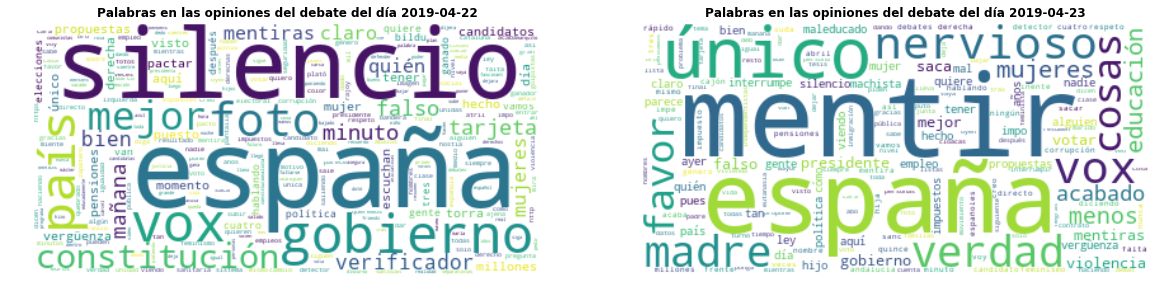

In [30]:
# Aplicar la función de preprocesado a los tweets
words_1 = preprocessing(text1["text"])
words_1 = [item for sublist in words_1 for item in sublist]
words_1 = collections.Counter(words_1) 
cloud_1 = wordcloud.WordCloud(background_color = "white", max_words = 1000).generate_from_frequencies(words_1)

words_2 = preprocessing(text2["text"])
words_2 = [item for sublist in words_2 for item in sublist]
words_2 = collections.Counter(words_2) 
cloud_2 = wordcloud.WordCloud(background_color = "white", max_words = 1000).generate_from_frequencies(words_2)

# Create the figure
plt.figure(figsize = (20,5))
# Make plot for the first day
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(cloud_1, interpolation = "bilinear")
plt.title("Palabras en las opiniones del debate del día 2019-04-22", weight = "bold")
# Make plot for the first day
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(cloud_2, interpolation = "bilinear")
plt.title("Palabras en las opiniones del debate del día 2019-04-23", weight = "bold")
# Show the figure
plt.show()

donde vemos que aparecen los grandes temas tratados, (como las pensiones, el indepententismo o la violencia de género) además de algunas anécdotas del debate (como la alusión al silencio, las acusaciones de nervios y mentiras o las alusiones a la constitución).

# 5. - Conclusiones y propuestas

En este trabajo hemos hecho un análisis de la opinión sobre los debates políticos de los días 2019-04-22 y 2019-04-23 usando pyspark, la API de Spark para python, y tweepy, la API de Twitter para python. Hemos estudiado la participación a través los tweets publicados por minuto y los usuarios más activos, hemos analizado las alusiones a políticos y partidos a través de sus menciones directas, y hemos analizado el texto de los tweets para obtener los temas más relevantes.

Otras propuestas de análisis, que quedan fuera del objetivo de este trabajo, pueden ser el análsis de la opinión subjetiva en los tweets mediante análisis de sentimiento; el análisis de alcance de los tweets estudiando el número de RTs, likes y comentarios; la elaboración de una red de usuarios conectados por los comentarios para identificar los usuarios más influyentes; la elaboración de un estudio geográfico de los tweets y las opiniones usando los datos de localización; o la creación de un algoritmo the machine learning que clasifique a los usuarios según intención de voto.

# 6. - Recursos

A continuación incluimos una lista de los recursos utilizados:  

[Pyspark in Docker](https://hub.docker.com/r/jupyter/pyspark-notebook)  
[Twitter Streaming API](https://developer.twitter.com/en/docs/tutorials/consuming-streaming-data.html)  
[Tweepy documentation](https://tweepy.readthedocs.io/en/v3.5.0/)  
[Pyspark documentation](https://spark.apache.org/docs/latest/api/python/index.html)